# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

### Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

In [3]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Picture.csv", header= None)

#print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = data_matrix.iloc[:,0].values
        y1 = data_matrix.iloc[:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')


        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet

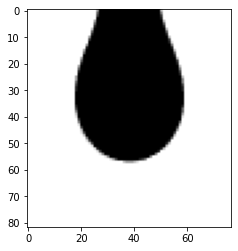

In [4]:
train_img = []

data_image = pd.read_csv("Data_folder/Picture.csv", header= None)
for img_name in data_image.iloc[0:32,3:].index + 1:
    # defining the image path
    image_path = 'Data_folder/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    
plt.imshow(train_img[0], cmap='gray')

# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:32,3:].values
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)
# (train_x_pic.shape, train_y_pic.shape), (val_x_pic.shape, val_y_pic.shape), (test_x_pic.shape, test_y_pic.shape)

# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = train_y_pic.astype(int)
train_y_pic = torch.from_numpy(train_y_pic)
# train_y_pic.shape, train_x_pic.shape

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = val_y_pic.astype(int)
val_y_pic = torch.from_numpy(val_y_pic)
# val_x_pic.shape, val_y_pic.shape

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = test_y_pic.astype(int)
test_y_pic = torch.from_numpy(test_y_pic)
# test_x_pic.shape, test_y_pic.shape

# converting the dataset into mini-batch dataset (input 4D -> 5D)
# To be finished after increaing pictures!!!!

### Deside to apply host or device


In [5]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


### Define the functions we need

In [17]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t].reshape(1, 1, 82, 77)        # reshape to 4D data (take it off after adding batch) 
            y = y_dataset[t].reshape(1, 160)              # reshape to 2D data (take it off after adding batch) 
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t].reshape(1, 1, 82, 77)      # reshape to 4D data (take it off after adding batch) 
            y = train_y_pic[t].reshape(1, 160)            # reshape to 2D data (take it off after adding batch) 
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


In [15]:
# testing cell
train_x_pic, train_y_pic

for t in range(len(train_x_pic)):
    pass
print(train_x_pic[t].shape)
print(train_y_pic[t].shape)

torch.Size([1, 82, 77])
torch.Size([160])


### Train PhysicsNet

epoch 1: train_loss = 18.7145, val_loss = 19.9079
epoch 2: train_loss = 24.8321, val_loss = 26.3118
epoch 3: train_loss = 4.5686, val_loss = 4.9333
epoch 4: train_loss = 38.0116, val_loss = 44.5906
epoch 5: train_loss = 15.8360, val_loss = 17.8911
epoch 6: train_loss = 4.1291, val_loss = 4.4719
epoch 7: train_loss = 9.6275, val_loss = 10.5894
epoch 8: train_loss = 2.8158, val_loss = 3.1510
epoch 9: train_loss = 9.2883, val_loss = 9.9862
epoch 10: train_loss = 20.9637, val_loss = 23.9373
epoch 11: train_loss = 1.4456, val_loss = 1.6376
epoch 12: train_loss = 3.8073, val_loss = 4.1268
epoch 13: train_loss = 6.8879, val_loss = 7.6167
epoch 14: train_loss = 2.6880, val_loss = 2.9658
epoch 15: train_loss = 0.6096, val_loss = 0.6969
epoch 16: train_loss = 2.8159, val_loss = 2.9719
epoch 17: train_loss = 2.2823, val_loss = 2.4781
epoch 18: train_loss = 2.8505, val_loss = 3.0465
epoch 19: train_loss = 1.9097, val_loss = 2.2807
epoch 20: train_loss = 0.6996, val_loss = 0.7562
epoch 21: train_lo

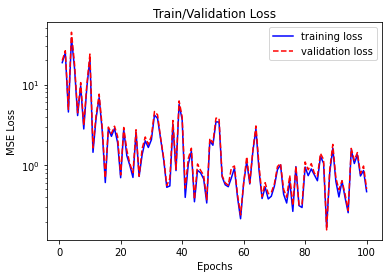

In [24]:
in_channel = 160
node_1 = 4096
node_2 = 4096
node_3 = 1024
node_4 = 512
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train_physics(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

### Visualization of outcomes

In [20]:
model_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_trained, x_test_example)
y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[32.3000, 12.6000],
        [33.9000, 14.1000],
        [41.2000, 10.9000],
        [41.7000, 13.8000],
        [40.7000, 18.2000],
        [35.2000, 12.9000],
        [42.9000, 14.5000],
        [38.2000, 10.4000],
        [35.4000, 15.7000],
        [39.0000, 10.8000],
        [35.8000, 16.9000],
        [35.3000, 13.5000],
        [38.8000, 12.8000],
        [37.8000, 16.8000],
        [42.3000, 19.0000]])
Prediction    = tensor([[34.4172, 12.8257],
        [33.6386, 13.7047],
        [41.1431, 11.1776],
        [43.3289, 14.1510],
        [39.5842, 18.0243],
        [37.1494, 13.0648],
        [44.2480, 15.0123],
        [38.8699, 10.4998],
        [36.1962, 16.0086],
        [39.7503, 10.8384],
        [34.8409, 16.5358],
        [35.9949, 13.4312],
        [40.0037, 12.8811],
        [37.0664, 16.6475],
        [40.9957, 18.7486]])


### Train PictureNet

epoch 1: train_loss = 1408.3259, val_loss = 2020.0831
epoch 2: train_loss = 3192.8809, val_loss = 4597.1328
epoch 3: train_loss = 6022.0430, val_loss = 8676.8428
epoch 4: train_loss = 2118.2322, val_loss = 3056.7554
epoch 5: train_loss = 110.0145, val_loss = 169.9065
epoch 6: train_loss = 8.1282, val_loss = 10.7999
epoch 7: train_loss = 2.1381, val_loss = 3.1468
epoch 8: train_loss = 1.8670, val_loss = 2.8182
epoch 9: train_loss = 1.1422, val_loss = 1.7303
epoch 10: train_loss = 0.8363, val_loss = 1.3149
epoch 11: train_loss = 0.3704, val_loss = 0.6020
epoch 12: train_loss = 0.2269, val_loss = 0.3666
epoch 13: train_loss = 0.1227, val_loss = 0.2156
epoch 14: train_loss = 0.1722, val_loss = 0.3048
epoch 15: train_loss = 0.2751, val_loss = 0.4102
epoch 16: train_loss = 0.2251, val_loss = 0.2973
epoch 17: train_loss = 0.2453, val_loss = 0.3557
epoch 18: train_loss = 0.2282, val_loss = 0.3547
epoch 19: train_loss = 0.0958, val_loss = 0.1522
epoch 20: train_loss = 0.1686, val_loss = 0.2432


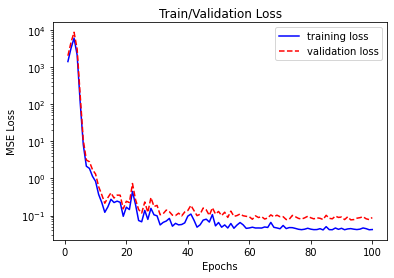

In [23]:
in_channel = 1
channel_1 = 64
channel_2 = 128
channel_3 = 256
node_1 = 4096
node_2 = 4096
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

train_picture(model_picture, optimizer, epoch)
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
torch.save(model_picture, PATH_PIC)

### Visualization of outcomes

In [ ]:
# To be done!!!